In [80]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline as Pipeline
from sklearn.model_selection import validation_curve
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests, json, random, time, tqdm, warnings
seed=111
path='/Users/Christian/Dropbox/Universitet/TSODAS/TSDS-gruppe-2019/Exam/'

### Loading data

In [407]:
r1=pd.read_pickle(path+'prices_0_200.pkl')
r2=pd.read_pickle(path+'prices_200_578.pkl')
r3=pd.read_pickle(path+'prices_577_777.pkl')
r4=pd.read_pickle(path+'prices_777_1000.pkl')
r5=pd.read_pickle(path+'prices_1000_1500.pkl')
r6=pd.read_pickle(path+'prices_1500_2000.pkl')
r7=pd.read_pickle(path+'prices_2000_3000.pkl')
r8=pd.read_pickle(path+'prices_3000_3240.pkl')
r9=pd.read_pickle(path+'prices_3240_4000.pkl')
r10=pd.read_pickle(path+'prices_4000_.pkl')
#print(len(r1), len(r2), len(r3), len(r4), len(r5), len(r6))
r=r1.append(r2, ignore_index=True)
r=r.append(r3, ignore_index=True)
r=r.append(r4, ignore_index=True)
r=r.append(r5, ignore_index=True)
r=r.append(r6, ignore_index=True)
r=r.append(r7, ignore_index=True)
r=r.append(r8, ignore_index=True)
r=r.append(r9, ignore_index=True)
r=r.append(r10, ignore_index=True)


r.to_pickle('scraping_data.pkl')


In [81]:
r=pd.read_pickle('scraping_data.pkl')
t=pd.read_pickle(path+'/Prediction/missings_190528.pkl')
r=r.append(t, ignore_index=True)


r=r.loc[(r.price !='-') & (r.price != 'Ingen')]
r=r.drop_duplicates(['origin','destination'])
r['price']=r['price'].str[4:].str.replace('.','')
r['price']=pd.to_numeric(r.price, errors='coerce')
r=r.drop_duplicates(['origin','destination'])
pred=pd.read_pickle(path+'FlightsML18.pkl')

pred_data=r.merge(pred, how='right', left_on=['origin','destination'], right_on=['Origin', 'Dest'])


missings = pred_data[pred_data['price'].isna()==True]
missings = missings[missings['count']>52]
missings = missings[missings['day'].isna()==True]
missings = missings[['Origin','Dest']]
missings.to_pickle('missings18.pkl')
pred_data=pred_data[pred_data['count']>=52]
pred_data = pred_data[pred_data['price'].isna()!=True]
pred_data = pred_data[pred_data['price']<5000]

### Exploring data

In [72]:
X_base=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','Origin','Dest', 'label']]
y_base=pred_data['price']

X=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef', 'Origin','Dest', 'label']]
y=pred_data['price']

X_base=pd.get_dummies(data=X_base, columns=['Origin', 'Dest', 'label'])
X=pd.get_dummies(data=X, columns=['Origin', 'Dest', 'label'])
#X.drop(['Origin','Dest'], inplace=True, axis=1)

In [73]:
print(len(y_test_base), len(X_test_base))
print(X_test_base)

1107 1107
      Distance  count  avg_time_mins  Origin_flights  Destination_flights  \
51         997   2465     154.160331          159579             191719.0   
797        719   7526     137.621337          751500             308206.0   
1246       326   1328      78.833073          182073              65242.0   
1993      1187    481     184.267368           53882             475273.0   
1296       355   1736      81.598361           28425             422170.0   
3438       874   1038     152.835176          170059             208119.0   
4661      1419    210     220.497585           50352             116158.0   
3974      1570    364     238.228650          129718             105895.0   
862        160   1712      81.261008           50734             308206.0   
2912       626    466     114.490826            2713             827656.0   
3327      1619    729     221.790859          475273             170059.0   
1891       116   1732      47.352668            7292             1

(array([291., 837., 961., 839., 415., 222.,  90.,  37.,  24.,  15.]),
 array([ 189. ,  665.3, 1141.6, 1617.9, 2094.2, 2570.5, 3046.8, 3523.1,
        3999.4, 4475.7, 4952. ]),
 <a list of 10 Patch objects>)

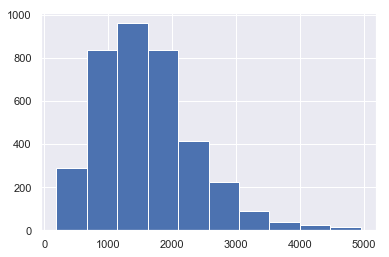

In [74]:
plt.hist(y)

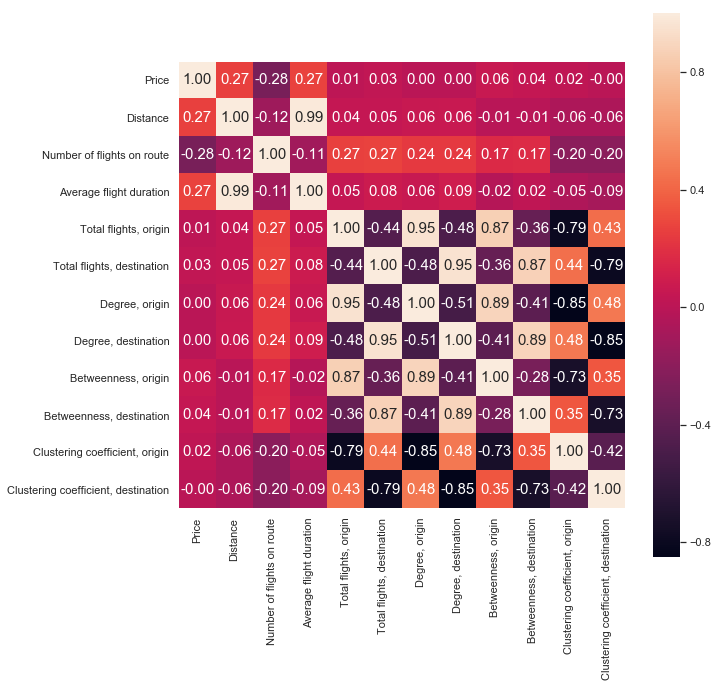

In [75]:
# Look at the Correlation matrix
cols = ['price','Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns', 'origin_clustcoef', 'dest_clustcoef']
names = ['Price', 'Distance', 'Number of flights on route', 'Average flight duration', 'Total flights, origin',
        'Total flights, destination', 'Degree, origin', 'Degree, destination', 'Betweenness, origin',
        'Betweenness, destination', 'Clustering coefficient, origin', 'Clustering coefficient, destination']
fig4, hm = plt.subplots(figsize=(10,10))
cm = np.corrcoef(pred_data[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=names, xticklabels=names)
plt.savefig(path+"Figures/corr_plot.pdf", bbox_inches='tight')


In [76]:
# Splitting the data into test and training
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
X_dev_base, X_test_base, y_dev_base, y_test_base = train_test_split(X_base, y_base, test_size=1/4, random_state=1)



In [79]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
alpha = np.linspace(1, 10, 10)
param_grid = {'l1_ratio': l1_space, 'alpha':alpha}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_dev, y_dev)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

KeyboardInterrupt: 

In [567]:
#Without network

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_dev_base, y_dev_base)

# Predict on the test set and compute metrics
y_pred_base = gm_cv.predict(X_test_base)
r2 = gm_cv.score(X_test_base, y_test_base)
mse = mean_squared_error(y_test_base, y_pred_base)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.3404525810556627
Tuned ElasticNet MSE: 323390.9739544955


In [42]:
# Model with polynomial features
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# Polynomial transformation


quadratic = PolynomialFeatures(degree=2)
X_quad_dev = quadratic.fit_transform(X_dev[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef']])
X_quad_dev = pd.DataFrame(X_quad_dev)
X_dev_drop = X_dev.drop(['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef'], axis=1)
X_dev_drop = X_dev_drop.reset_index()
X_quan_dev = pd.concat([X_quad_dev, X_dev_drop], axis=1, ignore_index=True)

X_quad_test = quadratic.fit_transform(X_test[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef']])
X_quad_test = pd.DataFrame(X_quad_test)
X_test_drop = X.drop(['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef'], axis=1)
X_test_drop = X_test_drop.reset_index()
X_quan_test = pd.concat([X_quad_test, X_test_drop], axis=1, ignore_index=True)


# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)

param_grid = [{'l1_ratio': l1_space}]

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(alpha=30)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_quan_dev, y_dev)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_quan_test)
r2 = gm_cv.score(X_quan_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').